# Neuromatch Academy: Week 2, Day 5, Tutorial 4

# VAEs and GANs : Implications of GAN Technology

__Content creators:__ Seungwook Han, Kai Xu, Akash Srivastava

__Content reviewers:__ Name Surname, Name Surname. 

__Content editors:__ Name Surname, Name Surname.

__Production editors:__ Name Surname, Name Surname.  

---

## Tutorial Objectives

The goal of this notebook is to experience first-hand how effective GANs are at modeling the data distribution and to question what the consequences of this technology may be.

By the end of this tutorial you will be able to:
- Understand the efficacy of GANs in modeling the data distribution (e.g., faces)
- Understand the energy inefficiency / environmental impact of training these large generative models
- Understand the implications of this technology (ethics, environment, etc)

In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1-omVjYriCQumx1q_dtAGw-gWmnx7uPz5" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

Video available at https://youtu.be/ZtWFeUZgfVk


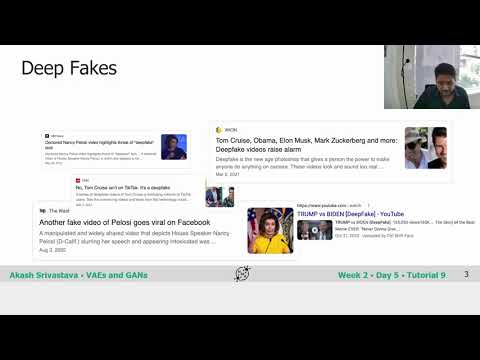

In [2]:
#@title Video 1: Ethical Issues
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ZtWFeUZgfVk", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

---

# Section 1: Faces Quiz 

In [3]:
#@title
from IPython import display
from IPython.display import IFrame
IFrame(src='https://docs.google.com/forms/d/e/1FAIpQLSeGjn2S2bn6Q1qWjVgDS5LG7G1GsQQh2Q0T9dEUO1z5_W0yYg/viewform?usp=sf_link', width=900, height=600)

---

# Section 2: Energy Efficiency Quiz 

In [4]:
#@title
IFrame(src='https://docs.google.com/forms/d/e/1FAIpQLSe8suNt4ZmadSr_6IWq6s_nUYxC1VCpjR2cBBmQ7cR_5znCZw/viewform?usp=sf_link', width=900, height=600)

# Summary

In this section, we learned about the broader ethical implications of GAN technology on society through deepfakes and their tremendous energy inefficiency.

On the brighter side, as we learned throughout the week, GANs are very effective in modeling the data distribution and have many practical applications.

For example, as personalized healthcare and applications of AI in healthcare rise, the need to remove any Personally Identifiable Information (PII) becomes more important. As shown in this paper (https://link.springer.com/chapter/10.1007/978-3-030-45385-5_36), GANs can be leveraged to anonymize healthcare data.

As a food for thought, what are some other practical applications of GANs that you can think of?


# GAN Recap

In [5]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1s8jHcZUudPp0h1yZLHRI9Rk8hz3zuoUS" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

Video available at https://youtu.be/7nUjFG3N04I


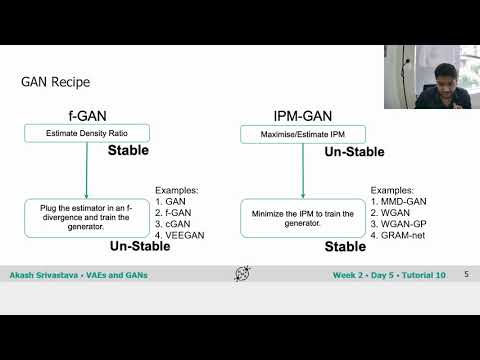

In [6]:
#@title Video 2: Recap and advanced topics
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="7nUjFG3N04I", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video